# 수수료

수수료 SHAP 영향도 Top10


,변수,SHAP 영향도
1,num__자동이체금액,0.009735
3,num__인터넷뱅킹거래금액,0.007636
0,num__요구불예금잔액,0.007021
4,num__신용카드사용금액,0.006795
2,num__스마트뱅킹거래금액,0.004131
5,num__고신용비중,0.002860
24,cat__법인_고객등급_우수,0.001710
22,cat__업종_대분류_제조업,0.001389
13,cat__업종_대분류_부동산업,0.001251
11,cat__업종_대분류_도매 및 소매업,0.001216


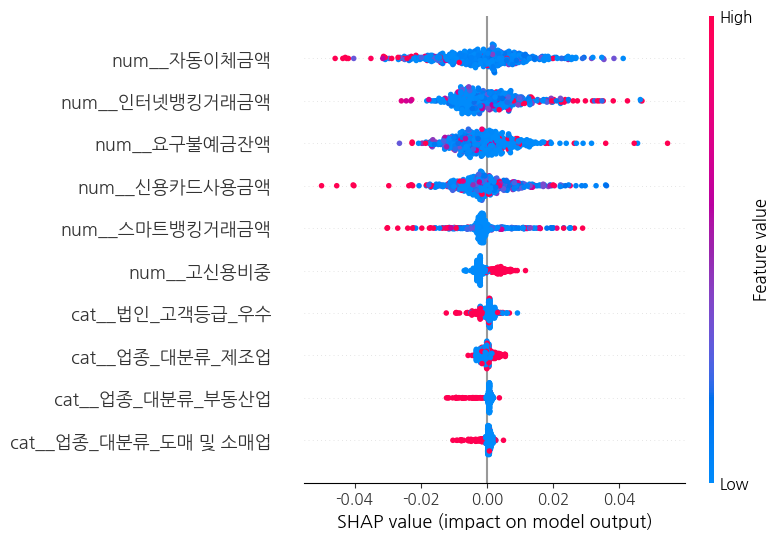

In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 수수료 수익 타깃 로딩
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

fee_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")].index[0]: "수수료수익"})
)
fee_target_df.index = pd.to_datetime(fee_target_df.index, format="%Y년%m월")
fee_target_df = fee_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})


# -----------------------------
# 2. 입력 데이터 로딩 및 병합
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, fee_target_df, on="기준년월", how="inner").dropna(subset=["수수료수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

# -----------------------------
# 3. 타깃 및 파생 변수 생성
# -----------------------------
merged["수수료_per고객"] = merged["수수료수익"] / merged["고객수"]
y = np.log1p(merged["수수료_per고객"])

merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

# -----------------------------
# 4. 설명변수 선택
# -----------------------------
features = [
    "요구불예금잔액", "자동이체금액", "스마트뱅킹거래금액",
    "인터넷뱅킹거래금액", "신용카드사용금액", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 5. 샘플링 및 전처리
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# -----------------------------
# 6. XGBoost 모델 학습
# -----------------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])
pipeline.fit(X_sample, y_sample)

# -----------------------------
# 7. SHAP 값 계산 및 시각화
# -----------------------------
X_transformed = preprocessor.transform(X_sample)

explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

mean_abs_shap_sec = np.abs(shap_values.values).mean(axis=0)
shap_df_sec = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향도": mean_abs_shap_sec
}).sort_values(by="SHAP 영향도", ascending=False)

print("수수료 SHAP 영향도 Top10")
display(shap_df_sec.head(10))

# 요약 시각화 (summary_plot)
shap.summary_plot(
    shap_values.values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)

# 신탁 

신탁수익 SHAP 영향도 Top10


,변수,SHAP 영향력
0,num__신탁잔액,0.002487
26,cat__퇴직연금좌수_0개,0.002409
24,cat__법인_고객등급_일반,0.002043
1,num__퇴직연금잔액,0.001965
4,num__고신용비중,0.001127
12,cat__업종_대분류_부동산업,0.000858
23,cat__법인_고객등급_우수,0.000843
5,num__업종수,0.000723
3,num__거치식예금잔액,0.000583
21,cat__업종_대분류_제조업,0.000514


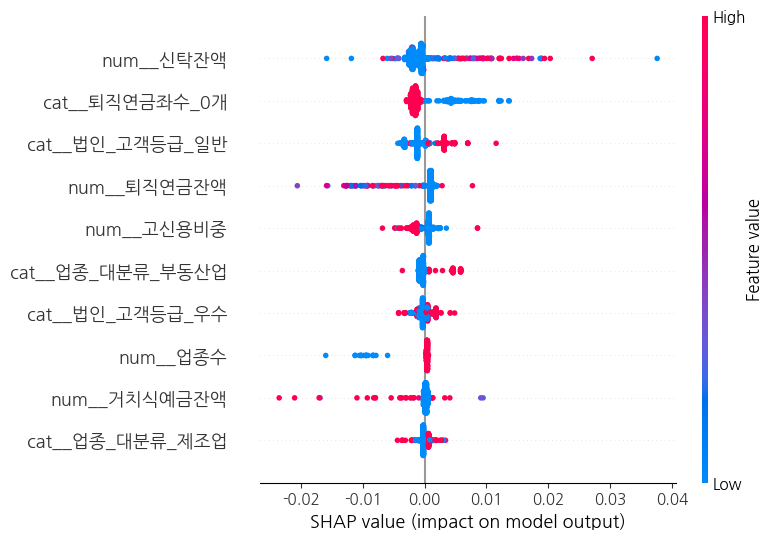

In [6]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 신탁 수익 타깃 로딩
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")
trust_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")].index[0]: "신탁수익"})
)
trust_target_df.index = pd.to_datetime(trust_target_df.index, format="%Y년%m월")
trust_target_df = trust_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 병합 및 타깃
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")
merged = pd.merge(df, trust_target_df, on="기준년월", how="inner").dropna(subset=["신탁수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]
merged["신탁_per고객"] = merged["신탁수익"] / merged["고객수"]
y = np.log1p(merged["신탁_per고객"])

# -----------------------------
# 3. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "신탁잔액", "퇴직연금잔액", "수익증권잔액", "거치식예금잔액",
    "퇴직연금좌수", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 4. 전처리 + 샘플링
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 5. XGBoost 학습 및 SHAP 계산
# -----------------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])
pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.transform(X_sample)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, 
                           feature_names=feature_names, algorithm="tree")
shap_values = explainer(X_transformed)

# -----------------------------
# 6. SHAP Top10 변수 시각화 (dot plot)
# -----------------------------
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "변수": feature_names,
    "SHAP 영향력": mean_abs_shap
}).sort_values(by="SHAP 영향력", ascending=False)

print("신탁수익 SHAP 영향도 Top10")
display(shap_df.head(10))

top10_features = shap_df["변수"].head(10).tolist()
top10_indices = [i for i, name in enumerate(feature_names) if name in top10_features]

shap.summary_plot(
    shap_values.values[:, top10_indices],
    features=X_transformed[:, top10_indices],
    feature_names=[feature_names[i] for i in top10_indices],
    plot_type="dot"
)

# 외환

외환수익 SHAP 영향도 Top10


,변수,SHAP 영향도
3,num__자동이체금액,0.131426
4,num__인터넷뱅킹거래금액,0.114885
2,num__요구불예금잔액,0.111986
14,cat__업종_대분류_건설업,0.024378
29,cat__업종_대분류_제조업,0.022914
18,cat__업종_대분류_도매 및 소매업,0.018996
20,cat__업종_대분류_부동산업,0.015567
0,num__외환_수출실적금액,0.014311
5,num__고신용비중,0.013910
32,cat__법인_고객등급_일반,0.013748


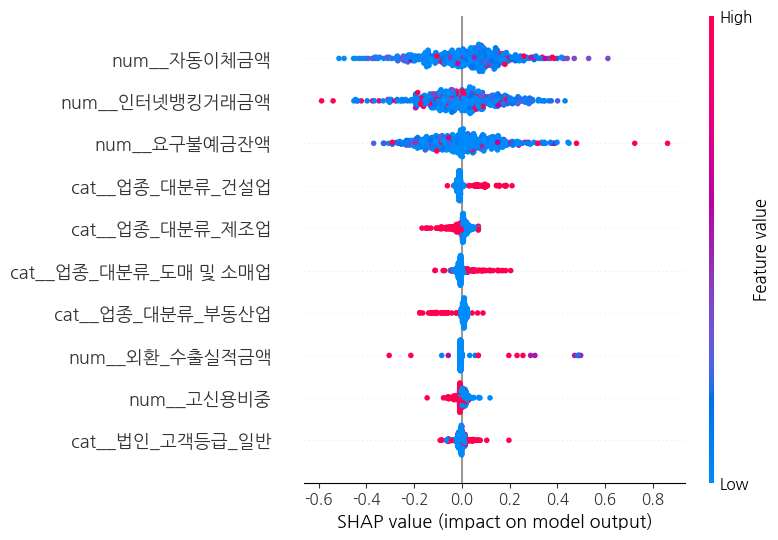

In [7]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 데이터 불러오기
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# -----------------------------
# 외환수익 타깃 구성
# -----------------------------
def format_target(df, colname):
    df = df.drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%Y년%m월")
    return df

fx_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "외환관련 손익:당분기")]
fx_df = format_target(fx_income, "외환수익")
fx_df = fx_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

merged_fx = pd.merge(df, fx_df, on="기준년월", how="inner").dropna(subset=["외환수익"])
merged_fx["고객수"] = merged_fx.groupby("기준년월")["법인_고객등급"].transform("count")
merged_fx = merged_fx[merged_fx["고객수"] > 0]
merged_fx["외환_per고객"] = merged_fx["외환수익"] / merged_fx["고객수"]
merged_fx = merged_fx[merged_fx["외환_per고객"] > 0].dropna(subset=["외환_per고객"])
y_fx = np.log1p(merged_fx["외환_per고객"])

# -----------------------------
# 설명변수 정의
# -----------------------------
merged_fx["고신용비중"] = (merged_fx["법인_고객등급"] == "최우수").astype(int)
merged_fx["업종수"] = merged_fx.groupby("기준년월")["업종_대분류"].transform("nunique")

X_fx = merged_fx[
    [
        "외환_수출실적금액", "외환_수입실적금액",
        "외환_수출실적거래건수", "외환_수입실적거래건수",
        "요구불예금잔액", "자동이체금액", "인터넷뱅킹거래금액",
        "고신용비중", "업종수", "법인_고객등급", "업종_대분류"
    ]
]

# -----------------------------
# 전처리 + XGBoost + SHAP
# -----------------------------
X_sample = X_fx.sample(n=500, random_state=42)
y_sample = y_fx.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])

pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

mean_abs_shap_fx = np.abs(shap_values.values).mean(axis=0)
shap_df_fx = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향도": mean_abs_shap_fx
}).sort_values(by="SHAP 영향도", ascending=False)

print("외환수익 SHAP 영향도 Top10")
display(shap_df_fx.head(10))

shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)

# 유가증권 

유가증권수익 SHAP 영향도 Top10


,변수,SHAP 영향도
2,num__자동이체금액,0.103949
4,num__업종수,0.098678
1,num__요구불예금잔액,0.090037
27,cat__법인_고객등급_일반,0.014398
34,cat__ATM거래건수_2건초과 5건이하,0.012331
37,cat__ATM거래건수_50건 초과,0.012274
31,cat__ATM거래건수_1건,0.011697
13,cat__업종_대분류_도매 및 소매업,0.011234
26,cat__법인_고객등급_우수,0.010670
3,num__고신용비중,0.009810


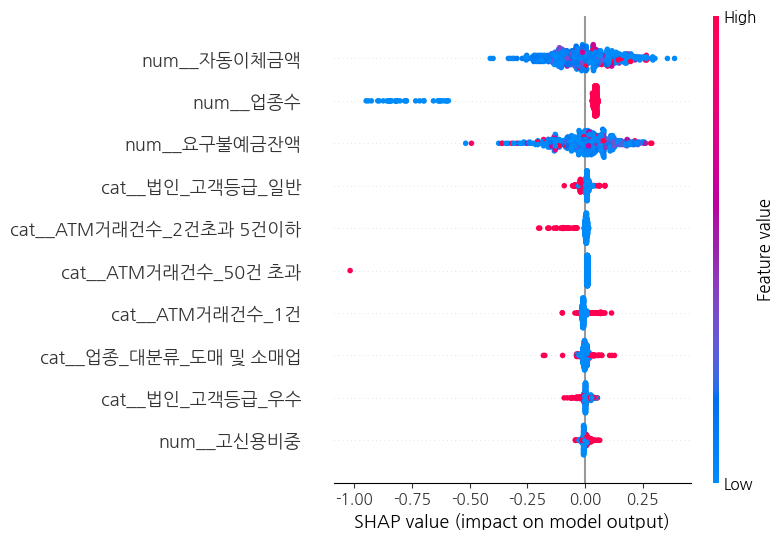

In [8]:
# -----------------------------
# 유가증권수익 타깃 구성
# -----------------------------
sec_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "유가증권 손익:당분기")]
sec_df = format_target(sec_income, "유가증권수익")
sec_df = sec_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

merged_sec = pd.merge(df, sec_df, on="기준년월", how="inner").dropna(subset=["유가증권수익"])
merged_sec["고객수"] = merged_sec.groupby("기준년월")["법인_고객등급"].transform("count")
merged_sec = merged_sec[merged_sec["고객수"] > 0]
merged_sec["유가_per고객"] = merged_sec["유가증권수익"] / merged_sec["고객수"]
merged_sec = merged_sec[merged_sec["유가_per고객"] > 0].dropna(subset=["유가_per고객"])
y_sec = np.log1p(merged_sec["유가_per고객"])

# -----------------------------
# 설명변수 정의
# -----------------------------
merged_sec["고신용비중"] = (merged_sec["법인_고객등급"] == "최우수").astype(int)
merged_sec["업종수"] = merged_sec.groupby("기준년월")["업종_대분류"].transform("nunique")

X_sec = merged_sec[
    [
        "수익증권잔액", "수익증권좌수", "요구불예금잔액",
        "자동이체금액", "ATM거래건수",
        "고신용비중", "업종수", "법인_고객등급", "업종_대분류"
    ]
]

# -----------------------------
# 전처리 + XGBoost + SHAP
# -----------------------------
X_sample = X_sec.sample(n=500, random_state=42)
y_sample = y_sec.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])

pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

mean_abs_shap_sec = np.abs(shap_values.values).mean(axis=0)
shap_df_sec = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향도": mean_abs_shap_sec
}).sort_values(by="SHAP 영향도", ascending=False)

print("유가증권수익 SHAP 영향도 Top10")
display(shap_df_sec.head(10))

shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)